In [1]:
# import pyforest
# print(pyforest.active_imports())
# set plt style
# plt.style.use('ggplot')

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["axes.labelsize"] = 16
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14

# 1.Load input and set output

In [6]:
inputFolder = Path("../data/0_raw")

GDRs = pd.read_excel(inputFolder / "V12_DR/V12_GDR_annotated_updated.xlsx")
Phenotype_categories = pd.read_excel(
    inputFolder / "Hayles_2013_OB_merged_categories.xlsx",
    sheet_name="All genes",
)

# merge the two dataframes
GDRs_with_phenotype_categories = pd.merge(
    GDRs.loc[:, :"GDL_50"],
    Phenotype_categories[
        [
            "Systematic ID",
            "Gene name",
            "Deletion mutant phenotype description",
            "Gene dispensability. This study",
            "Consistency at temperatures",
            "One or multi basic phenotypes",
            "Category",
        ]
    ],
    left_on="SysID",
    right_on="Systematic ID",
    how="left",
).drop(columns="Systematic ID")

# add verification results
V2E_28_correct = ["SPAC4F10.06","SPAC1805.06c","SPAC22G7.05","SPAC8C9.08","SPAC13C5.05c","SPAC1805.13","SPAC1296.06","SPAC22F3.11c","SPAC3F10.17","SPBC17G9.09","SPCC4B3.05c","SPCC364.07","SPBC776.03","SPCC1235.04c","SPCC13B11.01","SPBC3H7.07c","SPBC56F2.04","SPBC13G1.13","SPBC337.10c","SPCC24B10.21","SPAC9.13c","SPBC2D10.10c","SPBC36B7.03","SPCC1682.16","SPAC6F6.03c","SPAC5D6.06c","SPBC21D10.11c","SPBC1685.09"]
E2V_9_correct = ["SPBC577.09","SPBP8B7.29","SPBC2A9.10","SPCC1672.01","SPAC12B10.02c","SPAPB24D3.06c","SPAC1002.16c","SPBC36B7.09","SPAC17G8.02"]
E2V_6_incorrect = ["SPCC1682.03c","SPCC4G3.16","SPAC24C9.04","SPAC23D3.08","SPAC664.09","SPBP8B7.05c"]

GDRs_with_phenotype_categories.loc[GDRs_with_phenotype_categories["SysID"].isin(V2E_28_correct),"Verified by Shaokai"] = "correct_V2E"
GDRs_with_phenotype_categories.loc[GDRs_with_phenotype_categories["SysID"].isin(E2V_9_correct),"Verified by Shaokai"] = "correct_E2V"
GDRs_with_phenotype_categories.loc[GDRs_with_phenotype_categories["SysID"].isin(E2V_6_incorrect),"Verified by Shaokai"] = "incorrect_E2V"

outputFolder = Path("../results/GDR_vs_phenotype_categories")
outputFolder.mkdir(exist_ok=True)

In [10]:
set(V2E_28_correct) - set(GDRs_with_phenotype_categories["SysID"].unique())

{'SPCC4B3.05c'}

# 2.Find the inconsistent genes between GDR and phenotype categories

In [7]:
phenotype_WT2E = GDRs_with_phenotype_categories[
    (GDRs_with_phenotype_categories["Category"] == "WT")
    & (GDRs_with_phenotype_categories["GDR_50"] > 0.5)
].copy()

phenotype_SmallColonies2E = GDRs_with_phenotype_categories[
    (GDRs_with_phenotype_categories["Category"] == "small colonies")
    & (GDRs_with_phenotype_categories["GDR_50"] > 0.5)
].copy()

phenotype_SmallColonies2severeE = GDRs_with_phenotype_categories[
    (GDRs_with_phenotype_categories["Category"] == "small colonies")
    & (GDRs_with_phenotype_categories["GDR_50"] > 0.75)
].copy()

phenotype_E2WT = GDRs_with_phenotype_categories[
    (GDRs_with_phenotype_categories["Gene dispensability. This study"] == "E")
    & (GDRs_with_phenotype_categories["GDR_50"] < 0.2)
].copy()

# Save results

In [8]:
tmp_output = Path("../tmp/GDR_vs_phenotype_categories")
tmp_output.mkdir(exist_ok=True)

with pd.ExcelWriter(tmp_output / "GDRs_with_phenotype_categories.xlsx") as writer:
    GDRs_with_phenotype_categories.to_excel(
        writer, sheet_name="GDRs_with_phenotype_categories", index=False
    )
    phenotype_WT2E.to_excel(writer, sheet_name="WT (GDR>0.5)", index=False)
    phenotype_SmallColonies2E.to_excel(
        writer, sheet_name="small colonies (GDR>0.5)", index=False
    )
    phenotype_SmallColonies2severeE.to_excel(
        writer, sheet_name="small colonies (GDR>0.75)", index=False
    )
    phenotype_E2WT.to_excel(writer, sheet_name="E (GDR<0.2)", index=False)

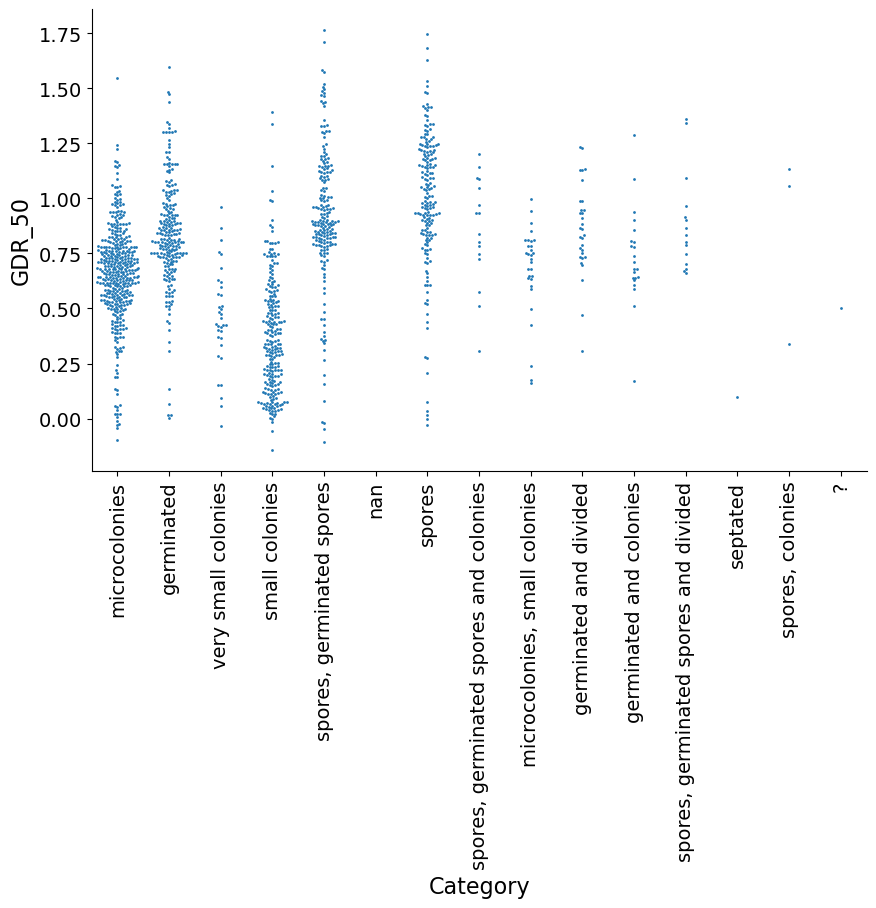

In [8]:
fig, ax = plt.subplots()


sns.swarmplot(data=GDRs_with_phenotype_categories[
    (GDRs_with_phenotype_categories["Category"] != "WT")
], 
x="Category", 
y="GDR_50", 
size=2,
ax=ax)

# rotate x-axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()
plt.close()